In [1]:
%matplotlib inline

import wget
import h5py

# fname = wget.download('https://sandbox.zenodo.org/record/1027635/files/mnist.hdf5?download=1')
fname = 'mnist.hdf5'
f = h5py.File(fname)

In [2]:
import dask.array as da
import numpy as np
from dask_ml.model_selection import train_test_split

X = da.from_array(f['training-images'][0:10000], chunks=1000)
y = da.from_array(f['training-labels'][0:10000], chunks=1000)

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.5, random_state=0)

# X_test = da.from_array(f['training-images'][10000:20000], chunks=1000)
# y_test = da.from_array(f['training-labels'][10000:20000], chunks=1000)

# X = da.from_array(f['test-images'], chunks=1000)
# y = da.from_array(f['test-labels'], chunks=1000)

In [3]:
X_train

dask.array<concatenate, shape=(5000, 784), dtype=uint8, chunksize=(500, 784), chunktype=numpy.ndarray>

In [4]:
from dask.distributed import Client, progress
from joblib import parallel_backend

client = Client(processes=False, threads_per_worker=4,
                n_workers=1, memory_limit='2GB')
client


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://192.168.192.2:8787/status,
Dashboard: http://192.168.192.2:8787/status,Workers: 1
Total threads: 4,Total memory: 1.86 GiB
Status: running,Using processes: False
Comm: inproc://192.168.192.2/142374/1,Workers: 1
Dashboard: http://192.168.192.2:8787/status,Total threads: 4
Started: Just now,Total memory: 1.86 GiB
Comm: inproc://192.168.192.2/142374/4,Total threads: 4
Dashboard: http://192.168.192.2:33755/status,Memory: 1.86 GiB
Nanny: None,


In [5]:
from sklearn.ensemble import RandomForestClassifier

yhat_test = dict()

with parallel_backend('dask'):

    clf = RandomForestClassifier()

    clf.fit(X_train, y_train)

    yhat_test['RandomForest'] = clf.predict(X_test)

print((yhat_test['RandomForest'] == y_test).mean().compute())

import pandas as pd
grp_test = pd.Series(yhat_test['RandomForest'].astype('str'), dtype='category')

0.937


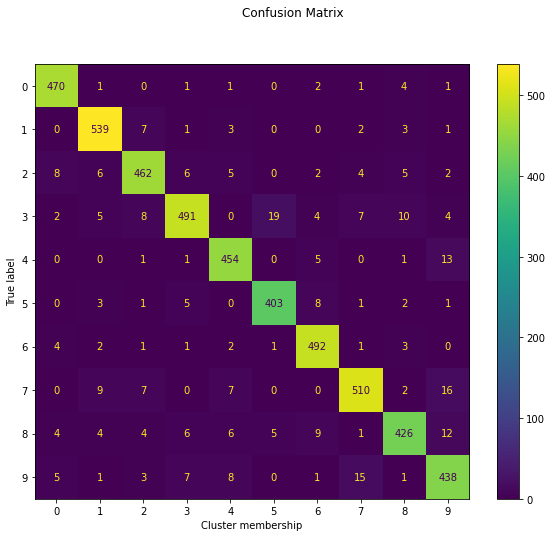

In [6]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_predictions(y_test.astype('str'), grp_test)
disp.figure_.suptitle("Confusion Matrix")
disp.figure_.set_size_inches((10, 8))
disp.ax_.set_xlabel('Cluster membership');

In [7]:
param_grid = clf.get_params()
# param_grid.update({
#     # 'max_features': ['sqrt', 'log2'],
#     'n_estimators': [100, 200],
#     'min_samples_leaf': [1, 3]
# })
param_grid

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [8]:
from dask_ml.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
estimator = KNeighborsClassifier()
param_grid = {
    'weights': ['uniform', 'distance'],
}
# param_grid = {}

grid_search = GridSearchCV(estimator,
                param_grid=param_grid,
                return_train_score=False,
                cv=3)

# with parallel_backend('dask'):
# with parallel_backend('dask', scatter=[X_train, y_train]):

grid_search.fit(X_train, y_train)

print(grid_search.best_estimator_.get_params())

yhat_test = grid_search.best_estimator_.predict(X_test)

print((yhat_test == y_test).mean().compute())

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
0.9408


In [9]:
import pandas as pd
pd.DataFrame(grid_search.cv_results_).head()

,params,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,param_weights
0,{'weights': 'uniform'},0.009099,0.001894,1.608067,0.254413,0.924415,0.924415,0.911164,0.9200,0.006246,2,uniform
1,{'weights': 'distance'},0.012018,0.001718,0.841897,0.294440,0.925615,0.931014,0.916567,0.9244,0.005960,1,distance


In [10]:
from dask_ml.cluster import KMeans
clf = KMeans(init='k-means++', n_clusters=10, init_max_iter=4, random_state=0)
%time clf.fit(X_train)
clf.labels_
clf.labels_[:10].compute()

CPU times: user 1min 2s, sys: 47 s, total: 1min 49s
Wall time: 27.9 s


array([3, 0, 2, 2, 9, 4, 3, 6, 3, 5], dtype=int32)

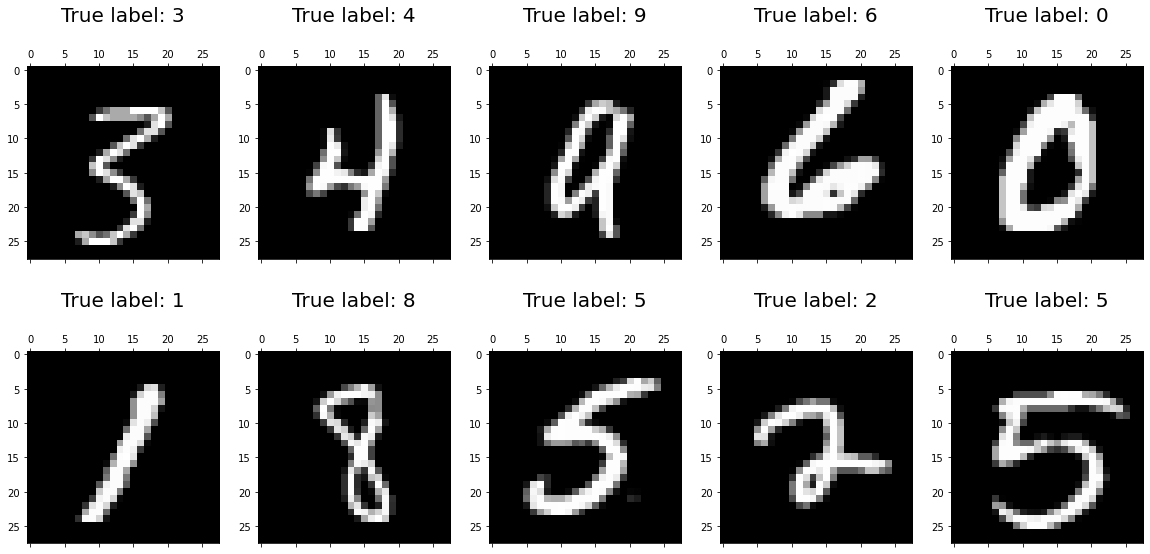

In [11]:
def plot_digits(X_, y_, num_figs, y_caption='True label'):

    from matplotlib.pyplot import figure
    from numpy import ceil

    num_rows = ceil(num_figs/5).astype(int)

    fig = figure(figsize=(20, 4.8*num_rows))

    # for j, ((i, img), (i, lab)) in enumerate(zip(X_, y_)):
    for j, (img, lab) in enumerate(zip(X_, y_)):

        tf = fig.add_subplot(num_rows, 5, j+1)
        tf.matshow(img.reshape((28, -1)), cmap='gray')
        tf.set_title('%s: %s\n' % (y_caption, lab.compute()), fontsize = 20)

        if j+1 == num_figs: break

plot_digits(X_train, y_train, 10)

In [12]:
from sklearn.ensemble import RandomForestClassifier

yhat_test = dict()

# module loading
clf = RandomForestClassifier()

clf.fit(X_train, y_train)

yhat_test['RandomForest'] = clf.predict(X_test)

print((yhat_test['RandomForest'] == y_test).mean().compute())

0.9388


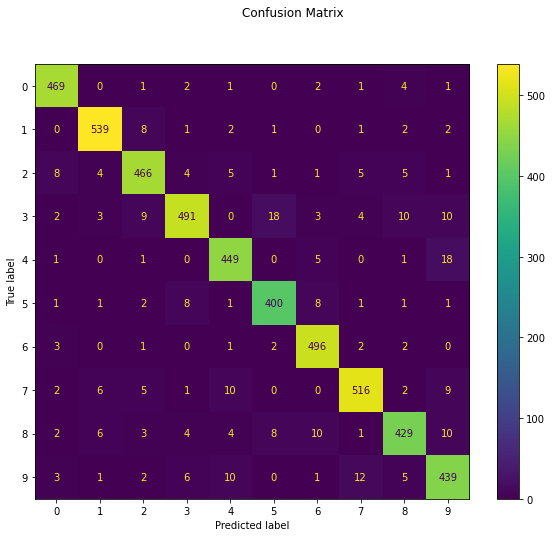

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_predictions(y_test, yhat_test['RandomForest'])
disp.figure_.suptitle("Confusion Matrix")
disp.figure_.set_size_inches((10, 8));

In [14]:
import numpy as np

cluster_label = dict()
for one in np.unique(grp_test):
    majority = y_test[(grp_test==one).values].value_counts()
    print('Majority of points in cluster', one, 'have label', majority.idxmax())
    cluster_label[str(one)] = majority.idxmax()

AttributeError: 'Array' object has no attribute 'value_counts'

In [ ]:
def subset_images(data, true_labels, cluster_assignment, digit, cluster):

    cond = (cluster_assignment == cluster).values & (true_labels == digit).values

    return data[cond], true_labels[cond], cluster_assignment[cond]


In [ ]:
# upright
d, l, c = subset_images(X_test, y_test, grp_test, '1', '0')
plot_digits(d, c, 5, 'cluster')

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/core.py:449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


AttributeError: 'bool' object has no attribute 'values'

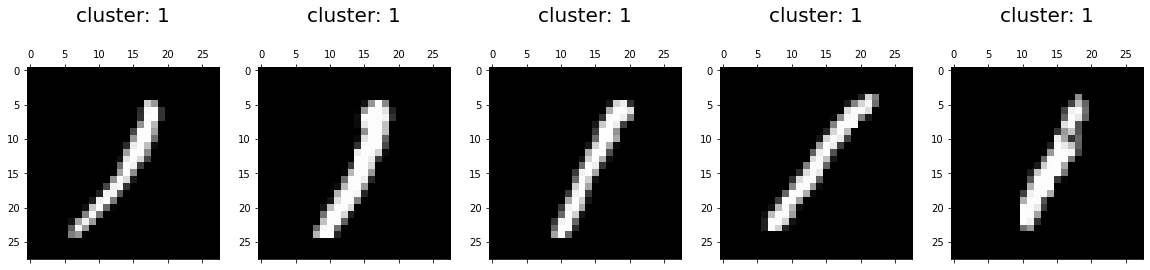

In [ ]:
# slanted
d, l, c = subset_images(X_test, y_test, grp_test, '1', '1')
plot_digits(d, c, 5, 'cluster')

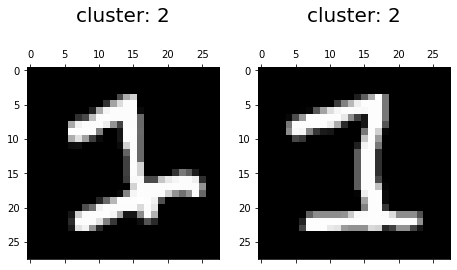

In [ ]:
# fancy
d, l, c = subset_images(X_test, y_test, grp_test, '1', '2')
plot_digits(d, c, 5, 'cluster')

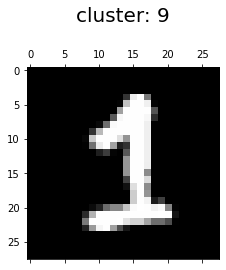

In [ ]:
# fancy upright
d, l, c = subset_images(X_test, y_test, grp_test, '1', '9')
plot_digits(d, c, 5, 'cluster')